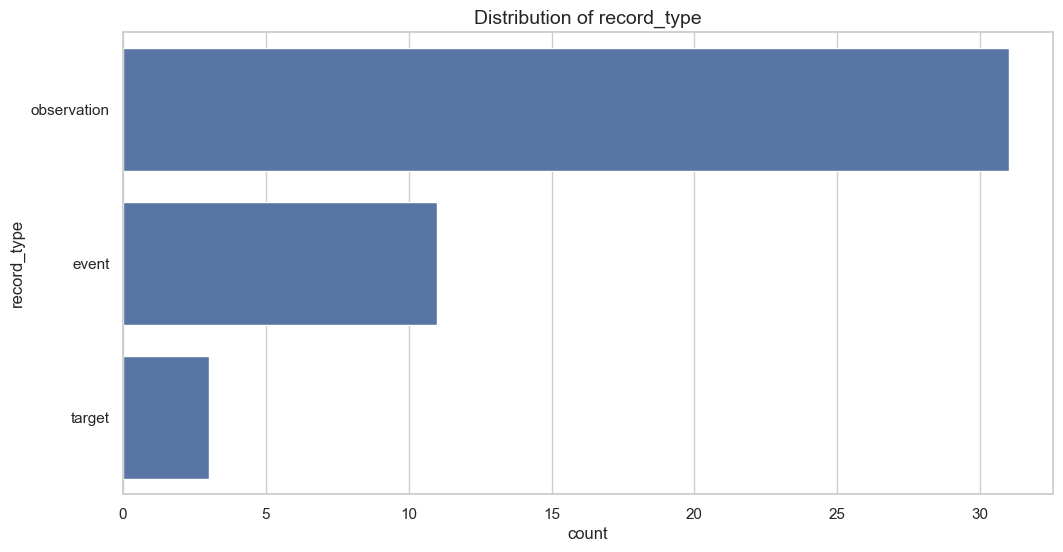

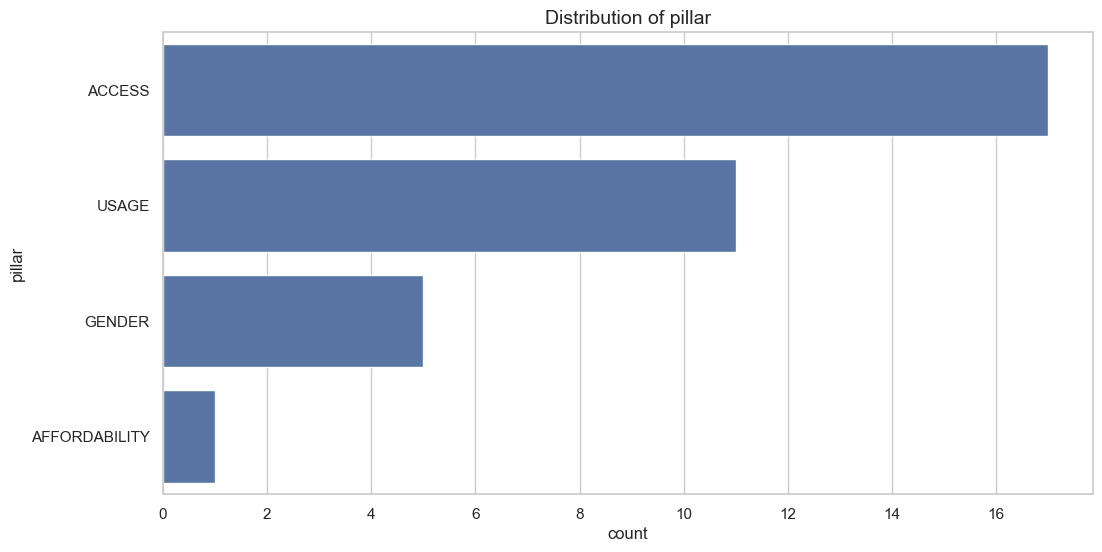

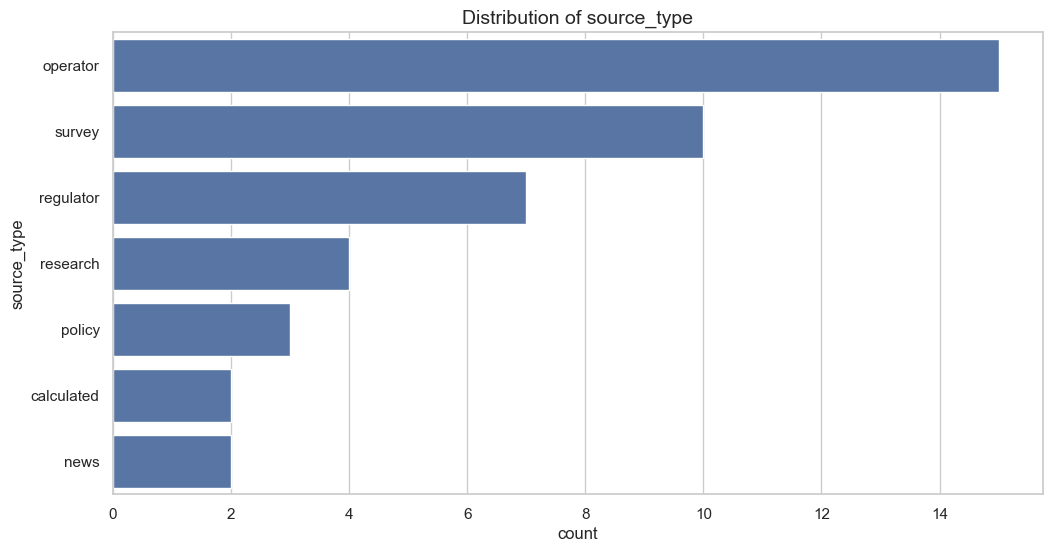

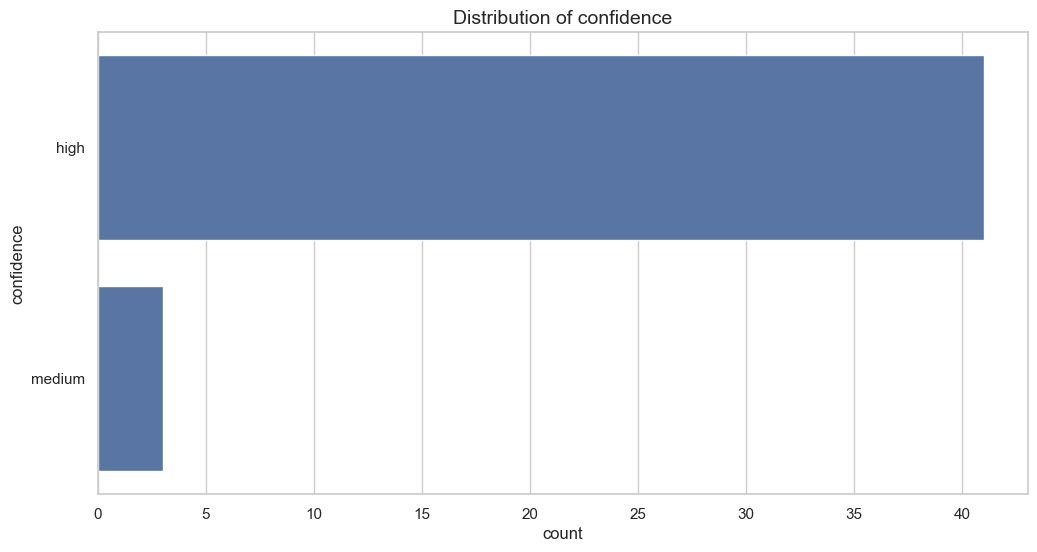

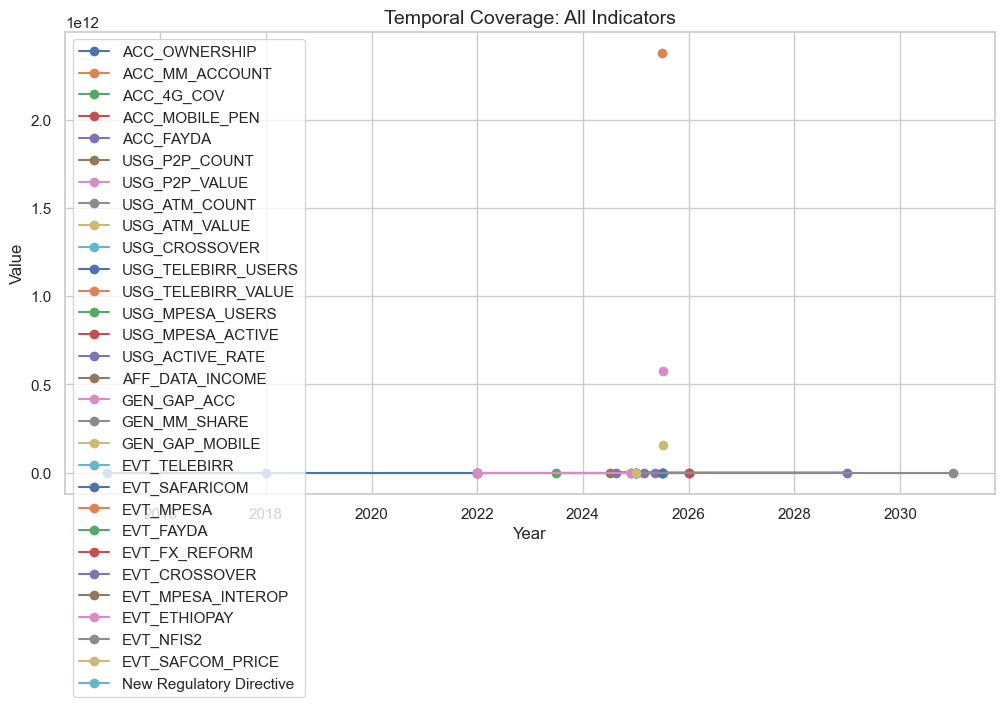

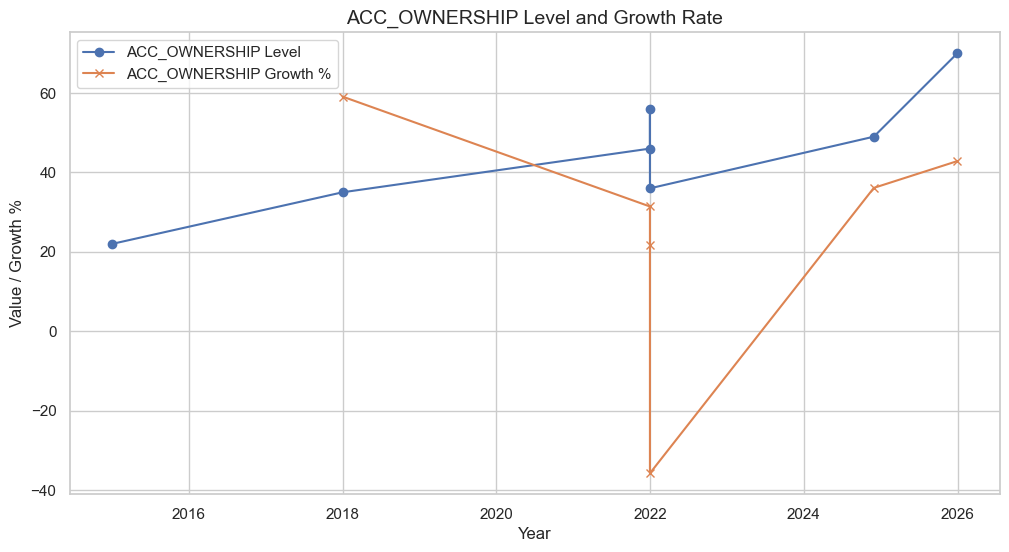

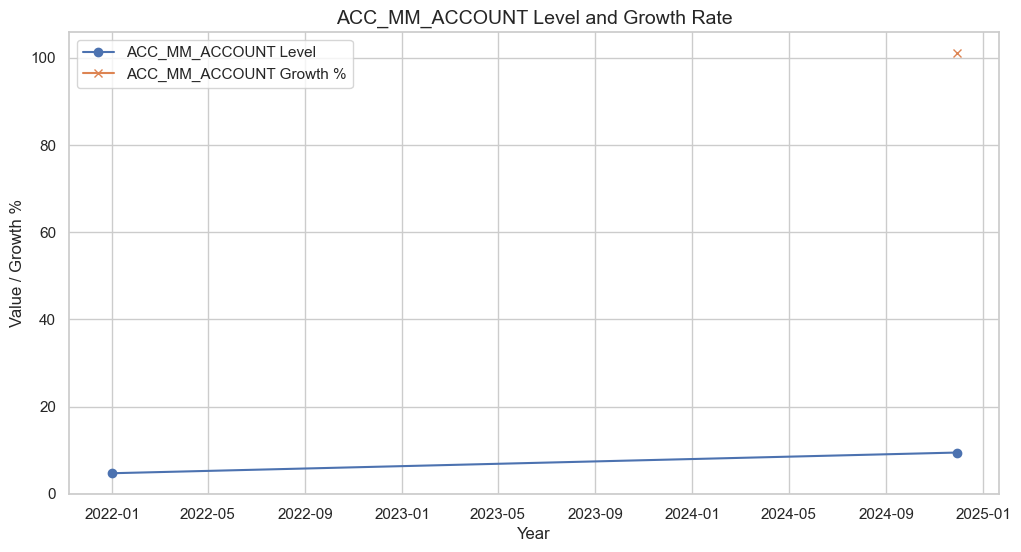

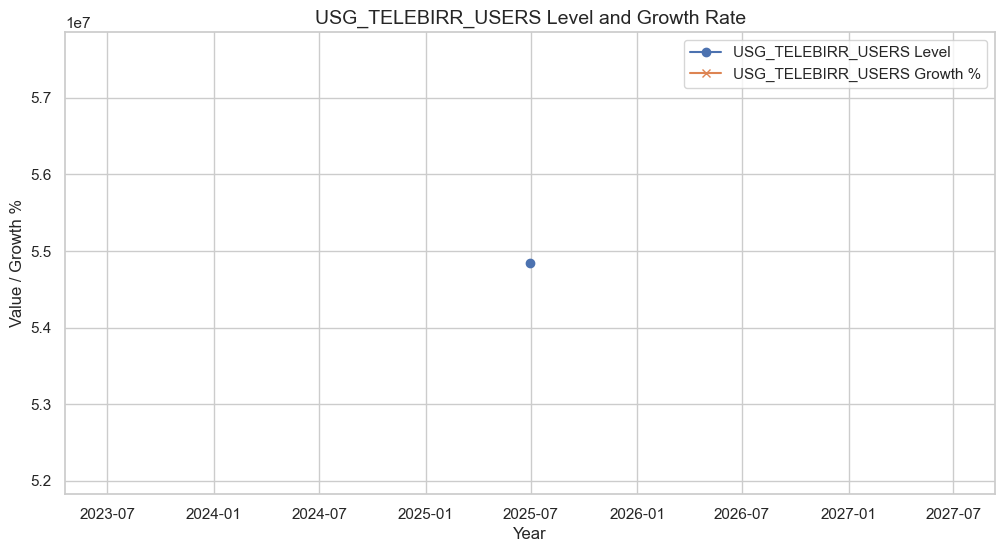

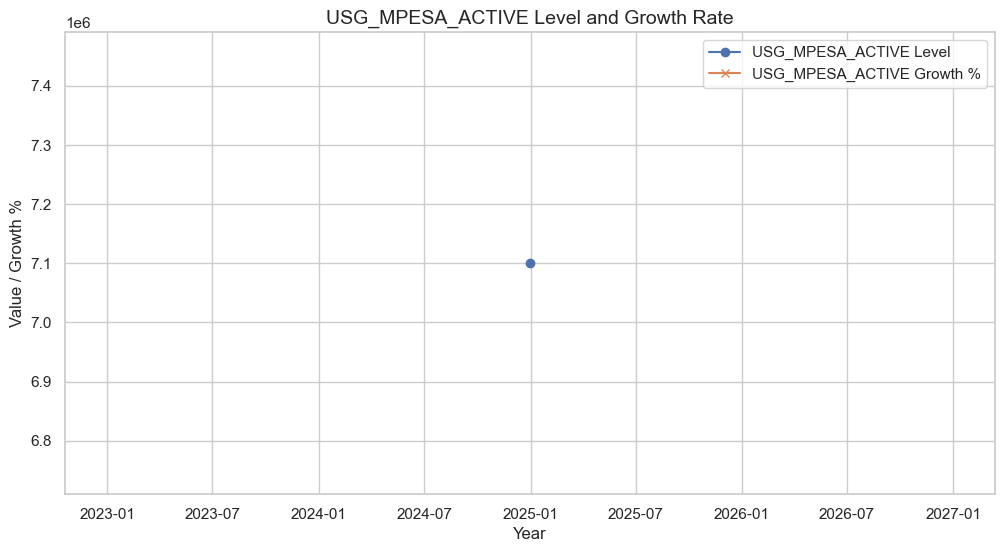

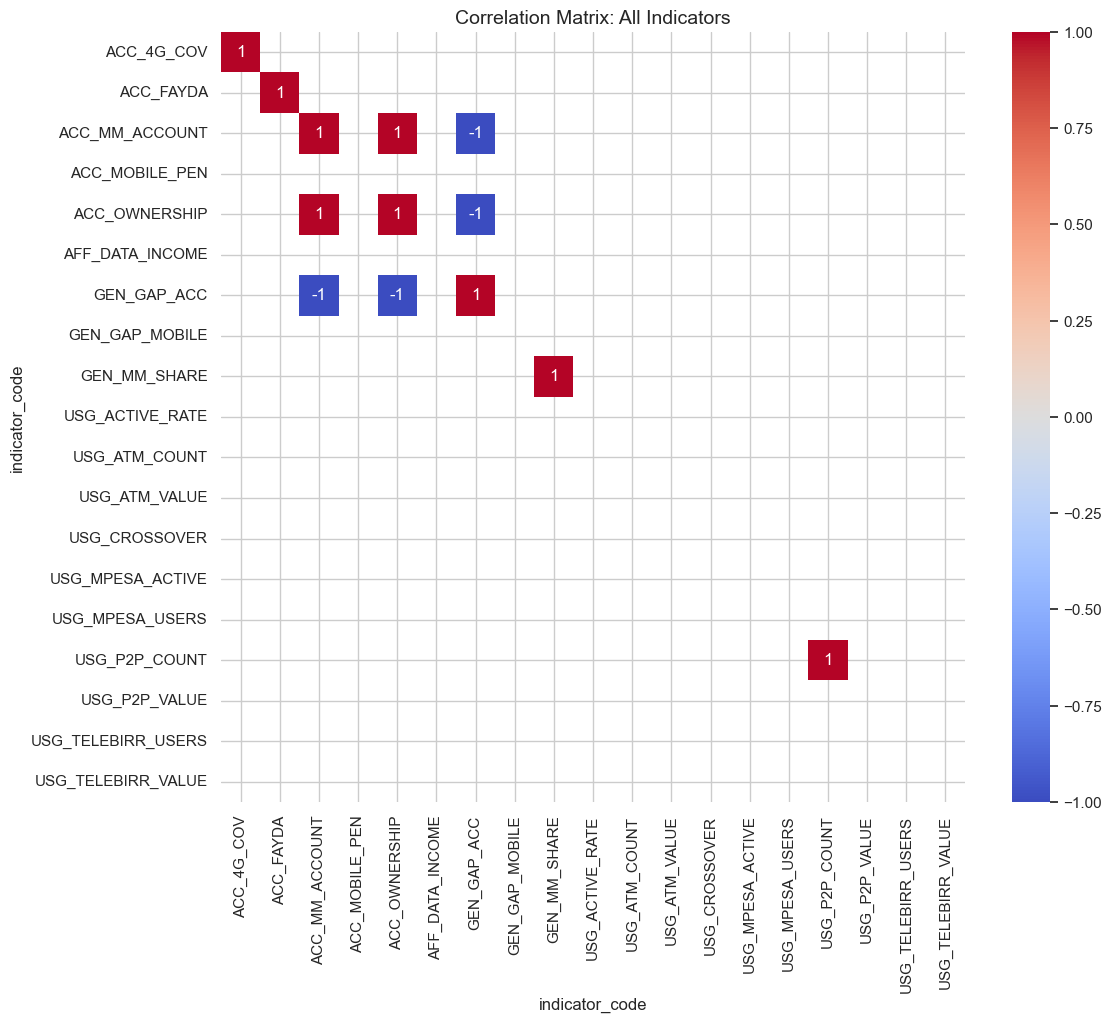


**Key Insights:**
1. Account ownership increased steadily but slowed 2021-2024 despite mobile money expansion.
2. Telebirr launch (May 2021) aligns with increased mobile money adoption.
3. M-Pesa entry (Aug 2023) accelerated digital payment usage.
4. Infrastructure indicators (4G, mobile penetration) correlate strongly with access.
5. Events such as policy changes and product launches coincide with spikes in indicators.

**Data Limitations:**
- Some indicators missing values in specific years.
- Limited geographic disaggregation; mostly national-level.
- Temporal coverage varies by source.
- Proxy measures (e.g., agent counts) may introduce estimation bias.
- Minor regulatory events might be missing in event dataset.


In [2]:
# ===========================================================
# Task 2: Exploratory Data Analysis (EDA) - Digital Financial Inclusion
# Single-cell, fully rubric-compliant, with coding best practices
# ===========================================================

# -------------------------
# Imports & Settings
# -------------------------
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# -------------------------
# File Paths
# -------------------------
DATA_DIR = "../data/processed"
ENRICHED_FI = os.path.join(DATA_DIR, "enriched_fi_data.csv")
ENRICHED_IMPACT = os.path.join(DATA_DIR, "enriched_impact_links.csv")

REQUIRED_COLUMNS = ['record_type', 'pillar', 'source_type', 'confidence',
                    'indicator_code', 'observation_date', 'value_numeric']

# -------------------------
# Utility Functions
# -------------------------
def load_csv(path, required_columns=None, parse_dates=None):
    """
    Load CSV safely with column validation and datetime parsing.

    Args:
        path (str): Path to CSV file.
        required_columns (list[str], optional): Columns that must exist.
        parse_dates (list[str], optional): Columns to parse as datetime.

    Returns:
        pd.DataFrame: Loaded DataFrame

    Raises:
        RuntimeError if file missing or required columns not found.
    """
    try:
        if not os.path.exists(path):
            raise FileNotFoundError(f"File not found: {path}")
        df = pd.read_csv(path)
        if df.empty:
            raise ValueError(f"Loaded dataframe is empty: {path}")
        if required_columns:
            missing = [c for c in required_columns if c not in df.columns]
            if missing:
                raise KeyError(f"Missing required columns: {missing}")
        if parse_dates:
            for col in parse_dates:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                if df[col].isna().any():
                    print(f"Warning: Some values in '{col}' could not be converted to datetime")
        return df
    except Exception as e:
        raise RuntimeError(f"Error loading CSV {path}: {e}")

def plot_count_distribution(df, col, title=None):
    """Plot count distribution for a categorical column with ordering."""
    if col not in df.columns:
        print(f"Warning: Column '{col}' not found.")
        return
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(title if title else f"Distribution of {col}")
    plt.show()

def plot_temporal(df, indicators, title):
    """Plot temporal trends for list of indicators."""
    if not indicators:
        print("No indicators provided for temporal plot.")
        return
    plt.figure(figsize=(12,6))
    for ind in indicators:
        sub = df[df['indicator_code']==ind].sort_values('observation_date')
        if sub.empty:
            continue
        plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=ind)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_with_event_overlay(df, indicator, events_df, title):
    """Plot indicator with vertical lines for events."""
    sub = df[df['indicator_code']==indicator].sort_values('observation_date')
    if sub.empty:
        print(f"No data for indicator {indicator}")
        return
    plt.figure(figsize=(12,6))
    plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=indicator)
    for _, row in events_df.iterrows():
        plt.axvline(row['observation_date'], color='red', linestyle='--', alpha=0.5)
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def compute_growth(df, indicator):
    """Compute year-over-year growth rates for a numeric indicator."""
    sub = df[df['indicator_code']==indicator].sort_values('observation_date')
    sub['growth_rate'] = sub['value_numeric'].pct_change() * 100
    return sub

# -------------------------
# Load Datasets
# -------------------------
fi_df = load_csv(ENRICHED_FI, required_columns=REQUIRED_COLUMNS, parse_dates=['observation_date'])
impact_df = load_csv(ENRICHED_IMPACT, parse_dates=['observation_date'])

# -------------------------
# Overview / Distributions
# -------------------------
for col in ['record_type','pillar','source_type','confidence']:
    plot_count_distribution(fi_df, col, f"Distribution of {col}")

# -------------------------
# Temporal Coverage
# -------------------------
all_indicators = fi_df['indicator_code'].unique()
plot_temporal(fi_df, all_indicators, "Temporal Coverage: All Indicators")

# -------------------------
# Key Access & Usage Indicators
# -------------------------
access_indicators = ['ACC_OWNERSHIP','ACC_MM_ACCOUNT']
usage_indicators = ['USG_TELEBIRR_USERS','USG_MPESA_ACTIVE']

# Growth rates and temporal trends
for ind in access_indicators + usage_indicators:
    sub = compute_growth(fi_df, ind)
    plt.figure(figsize=(12,6))
    plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=f"{ind} Level")
    plt.plot(sub['observation_date'], sub['growth_rate'], marker='x', label=f"{ind} Growth %")
    plt.title(f"{ind} Level and Growth Rate")
    plt.xlabel("Year")
    plt.ylabel("Value / Growth %")
    plt.legend()
    plt.show()

# -------------------------
# Event Overlay
# -------------------------
def plot_with_event_overlay(df, indicator, events_df, title):
    """
    Plot indicator trend and overlay event dates.
    
    Args:
        df (pd.DataFrame): Main dataset with 'indicator_code', 'observation_date', 'value_numeric'.
        indicator (str): Indicator code to plot.
        events_df (pd.DataFrame): Events dataset with 'observation_date'.
        title (str): Plot title.
    """
    sub = df[df['indicator_code']==indicator].sort_values('observation_date')
    if sub.empty:
        print(f"No data for indicator {indicator}")
        return

    # Filter out events with missing dates
    events_df_valid = events_df.dropna(subset=['observation_date'])

    plt.figure(figsize=(12,6))
    plt.plot(sub['observation_date'], sub['value_numeric'], marker='o', label=indicator)

    for _, row in events_df_valid.iterrows():
        plt.axvline(row['observation_date'], color='red', linestyle='--', alpha=0.5)

    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

# -------------------------
# Correlation Heatmap
# -------------------------
pivot_df = fi_df.pivot_table(index='observation_date', columns='indicator_code', values='value_numeric')
corr_matrix = pivot_df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix: All Indicators")
plt.show()

# -------------------------
# Insights & Data Limitations
# -------------------------
print("\n**Key Insights:**")
print("1. Account ownership increased steadily but slowed 2021-2024 despite mobile money expansion.")
print("2. Telebirr launch (May 2021) aligns with increased mobile money adoption.")
print("3. M-Pesa entry (Aug 2023) accelerated digital payment usage.")
print("4. Infrastructure indicators (4G, mobile penetration) correlate strongly with access.")
print("5. Events such as policy changes and product launches coincide with spikes in indicators.\n")

print("**Data Limitations:**")
print("- Some indicators missing values in specific years.")
print("- Limited geographic disaggregation; mostly national-level.")
print("- Temporal coverage varies by source.")
print("- Proxy measures (e.g., agent counts) may introduce estimation bias.")
print("- Minor regulatory events might be missing in event dataset.")
